# Saffman-Taylor instability

Working in the frame of reference moving at the non-dimensionalised unit velocity $\textbf{e}_U$ of the injected fluid.

initial-boundary value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\phi\frac{\partial c}{\partial t} + \textbf{u}\cdot\nabla c = \frac{1}{Pe}\nabla\cdot(\mathsf{D}\cdot\nabla c)$$

$$\nabla\cdot\textbf{u}=0$$

$$\textbf{u}=-\frac{\mathsf{K}}{\mu}\cdot(\nabla p + \mu\mathsf{K}^{-1}\cdot\textbf{e}_U)$$

mapping to porous convection equations defined in `demo/py/porous_convection.py`

$$
\begin{Bmatrix}
\phi \\
Ra \\ 
\mathsf{D} \\
\mathsf{K} \\
\mu \\
\rho \\ 
\textbf{e}_g 
\end{Bmatrix}
\mapsto
\begin{Bmatrix}
\phi \\
Pe \\ 
\mathsf{D} \\
\mathsf{K} \\
\mu \\
\mu \\
\mathsf{K}^{-1}\cdot\textbf{e}_U
\end{Bmatrix}
$$

## Example: $d=2$ rectangle

$$\Omega = [-L_x/2, L_x/2] \times [0, L_y]$$

$$
\begin{align*}
\phi &= 1 \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K} &= \mathsf{I}\\ 
\mu(c) &= \exp(-\Lambda c) \\
\end{align*}
$$

$$\textbf{n}\cdot\textbf{u}\vert_{x=-L_x/2,y}=-1$$

$$\textbf{n}\cdot\textbf{u}\vert_{x=L_x/2,y}=1$$

$$\textbf{n}\cdot\textbf{u}\vert_{x,y=0}=\textbf{n}\cdot\textbf{u}\vert_{x,y=L_y}=0$$

$$\implies\psi\vert_{x,y=0}=0~,~\psi\vert_{x,y=L_y}=-L_y~,~\psi\vert_{x=\pm L_x/2,y}=0$$

$$c_0(x,y)=\frac{1}{2}\left(1+\text{erf}\left(-\frac{x}{\epsilon L_x}\right)\right)+\mathcal{N}(x,y)$$

$$c(x=-L_x/2,y)=c(x=L_x/2,y)$$

$$\frac{\partial c}{\partial y}\bigg\vert_{x,y=0}=\frac{\partial c}{\partial y}\bigg\vert_{x,y=L_y}=0$$

$$\textbf{e}_U=\textbf{e}_x$$

In [2]:
import scipy.special as sp

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fdm import FiniteDifference, AB2, CN
from lucifex.fdm.ufl_operators import exp
from lucifex.fem import LUCiFExConstant as Constant
from lucifex.solver import BoundaryConditions
from lucifex.sim import integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, sinusoid_noise
from lucifex.viz import plot_colormap
from lucifex.io import write

from py.porous_convection import porous_convection_simulation


@configure_simulation(
    store_step=1,
    write_step=None,
)
def saffman_taylor_rectangle(
    Lx: float = 2.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    Pe: float = 5e2,
    Lmbda: float = 1e1,
    erf_eps: float = 1e-2,
    c_eps: float = 1e-6,
    c_freq: tuple[int, int] = (8, 8),
    dt_max: float = 0.25,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.25,
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
):
    Omega = rectangle_mesh(
        (-0.5 * Lx, 0.5 * Lx), 
        (0, Ly), 
        Nx, 
        Ny, 
        cell=cell,
    )
    dOmega = mesh_boundary(
        Omega,
        {
            "left": lambda x: x[0] + 0.5 * Lx,
            "right": lambda x: x[0] - 0.5 * Lx,
            "lower": lambda x: x[1],
            "upper": lambda x: x[1] - Ly,
        },
    )
    c_bcs = BoundaryConditions(
        ("neumann", dOmega.union, 0.0),
    )
    c_ics = SpatialPerturbation(
        lambda x: 0.5 * (1.0 + sp.erf(x[0] / (Lx * erf_eps))),
        sinusoid_noise(['neumann', 'neumann'], [Lx, Ly], c_freq),
        [Lx, Ly],
        c_eps,
    ) 
    psi_bcs = BoundaryConditions(
        ("dirichlet", dOmega['lower'], 0.0),
        ("dirichlet", dOmega['upper'], -Ly),
        ("dirichlet", dOmega['left', 'right'], lambda x: -x[1]),
    )
    Lmbda = Constant(Omega, Lmbda, 'Lmbda')
    viscosity = lambda c: exp(-Lmbda * c)

    simulation = porous_convection_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        egx=1,
        egy=None,
        Ra=Pe,
        density=viscosity,
        viscosity=viscosity,
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        psi_bcs=psi_bcs,
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv,
        D_diff=D_diff,
    )
    return simulation


simulation = saffman_taylor_rectangle(
    Lx=5.0,
    Ly=1.0,
    Nx=160,
    Ny=80,
    cell='quadrilateral', 
    Pe=100.0,
    Lmbda=5.0, 
    D_adv=AB2,
    D_diff=CN,
)

In [3]:
n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

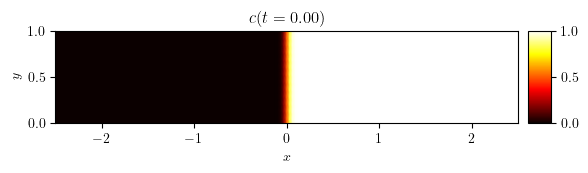

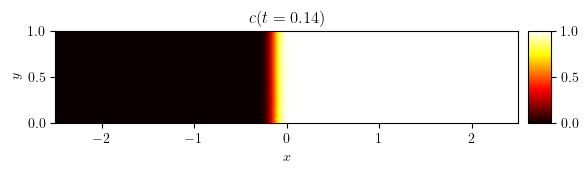

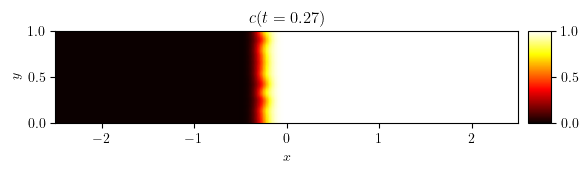

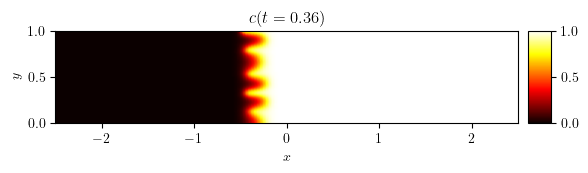

In [5]:
c, psi = simulation['c', 'psi']

i_qrt = int(0.25 * len(c.series))
i_mid = int(0.5 * len(c.series))
time_indices = (0, i_qrt, i_mid, -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'$c(t={c.time_series[i]:.2f})$')
    write(
        fig, 
        f'A20_saffman_taylor_c(t={c.time_series[i]:.2f})', 
        './figures', 
        file_ext=['pdf', 'png'], 
        close=False, 
        pickle=False,
    )